In [1]:
import sys
import os
from pathlib import Path
import torch
import pprint
sys.path.append(os.getcwd())
sys.path.append(str(Path(os.getcwd()).parent))
from utils import *
from configuration import *
sys.path.append('../utils/')
import FigureConfig as FC

In [9]:
args = parser.parse_args([])

dataname = []

result = []
for ds in range(13):
    args.DATASET = ds
    valid_loader, datainfo = GetDataLoader(args, 'valid', path='../dataset/')
    test_loader , datainfo = GetDataLoader(args, 'test',  path='../dataset/')
    dataname.append(datainfo['dataname'])
    result_seed = []
    for seed in range(10):
        args.SEED = seed
        result

        result_do = []
        for dropout in [0., 0.1]:
            args.dropout = dropout
            
            result_e = []
            for epsilon in [0., 0.1]:
                args.e_train = epsilon

                filename = f"./evaluation/result_data_{args.DATASET:02d}_{datainfo['dataname']}_seed_{args.SEED:02d}_epsilon_{args.e_train}_dropout_{args.dropout}.matrix"
                result_e.append(torch.load(filename))
            result_e = torch.stack(result_e)
            
            result_do.append(result_e)
        result_do = torch.stack(result_do)

        result_seed.append(result_do)
    result_seed = torch.stack(result_seed)

    result.append(result_seed)
result = torch.stack(result)

In [10]:
result.shape

torch.Size([13, 10, 2, 2, 500, 4, 2])

In [11]:
result_seed = result.mean(dim=[2, 3, 4])
result_seed_validation = result_seed[:, :,0, 1]
best_seeds = torch.argmax(result_seed_validation, dim=1)
final_result = result[torch.arange(result.size(0)), best_seeds]
final_result = final_result[:, :, :, :, :, 1]
final_result.shape

torch.Size([13, 2, 2, 500, 4])

In [24]:
final_result_check = final_result.mean(dim=[0,3])
final_result_check[:,:,3]

tensor([[0.5513, 0.5710],
        [0.5854, 0.5671]])

Analysis

In [13]:
nominal = final_result[:,0,0,:,:]
dropout = final_result[:,1,0,:,:]
variation = final_result[:,0,1,:,:]
both = final_result[:,1,1,:,:]

In [14]:
data_to_visualize = torch.stack([nominal, dropout, variation, both]).permute([1,0,2,3])
data_to_visualize.shape

torch.Size([13, 4, 500, 4])

In [15]:
import numpy as np
import pandas as pd

faults = [0,1,2,4]
for ds in [1,3,4,5,6,8,9,12]:
    data_to_save = []
    for fault in range(1,4):
        accuracy_without_fault = nominal[ds, 0, 0].view(1,1)
        data = nominal[ds, :, fault].view(500,1)
        data = torch.cat([accuracy_without_fault, data], dim=0)
        pre_label = torch.linspace(0,500,501).view(501,1)
        pre_label2 = torch.linspace(0,500,501).view(501,1) * 0
        pre_label2[0] = 1
        label = torch.ones_like(data).view(501,1) * 10 * fault
        saving_data = torch.cat([pre_label, pre_label2, data, label], dim=1)
        data_to_save.append(saving_data)
    saving_data = torch.cat(data_to_save, dim=0)
    name = dataname[ds]
    df = pd.DataFrame(saving_data.numpy(), columns=['Unnamed: 0', 'fault', 'acc', 'fault_type'])
    df['fault'] = df['fault'].replace({0: '', 1: 'no fault'})
    df['fault_type'] = df['fault_type'].replace({10: 'single', 20: 'double', 30: 'quatre'})
    # np.savetxt(f'./excel/nominal_{name}.csv', saving_data, delimiter=',', fmt='%s')
    df.to_csv(f'./excel/nominal_{name}.csv', index=False)

for ds in [1,3,4,5,6,8,9,12]:
    data_to_save = []
    for fault in range(1,4):
        accuracy_without_fault = dropout[ds, 0, 0].view(1,1)
        data = dropout[ds, :, fault].view(500,1)
        data = torch.cat([accuracy_without_fault, data], dim=0)
        pre_label = torch.linspace(0,500,501).view(501,1)
        pre_label2 = torch.linspace(0,500,501).view(501,1) * 0
        pre_label2[0] = 1
        label = torch.ones_like(data).view(501,1) * 10 * fault
        saving_data = torch.cat([pre_label, pre_label2, data, label], dim=1)
        data_to_save.append(saving_data)
    saving_data = torch.cat(data_to_save, dim=0)
    name = dataname[ds]
    df = pd.DataFrame(saving_data.numpy(), columns=['Unnamed: 0', 'fault', 'acc', 'fault_type'])
    df['fault'] = df['fault'].replace({0: '', 1: 'no fault'})
    df['fault_type'] = df['fault_type'].replace({10: 'single', 20: 'double', 30: 'quatre'})
    # np.savetxt(f'./excel/dropout_{name}.csv', saving_data, delimiter=',', fmt='%s')
    df.to_csv(f'./excel/dropout_{name}.csv', index=False)

for ds in [1,3,4,5,6,8,9,12]:
    data_to_save = []
    for fault in range(1,4):
        accuracy_without_fault = variation[ds, 0, 0].view(1,1)
        data = variation[ds, :, fault].view(500,1)
        data = torch.cat([accuracy_without_fault, data], dim=0)
        pre_label = torch.linspace(0,500,501).view(501,1)
        pre_label2 = torch.linspace(0,500,501).view(501,1) * 0
        pre_label2[0] = 1
        label = torch.ones_like(data).view(501,1) * 10 * fault
        saving_data = torch.cat([pre_label, pre_label2, data, label], dim=1)
        data_to_save.append(saving_data)
    saving_data = torch.cat(data_to_save, dim=0)
    name = dataname[ds]
    df = pd.DataFrame(saving_data.numpy(), columns=['Unnamed: 0', 'fault', 'acc', 'fault_type'])
    df['fault'] = df['fault'].replace({0: '', 1: 'no fault'})
    df['fault_type'] = df['fault_type'].replace({10: 'single', 20: 'double', 30: 'quatre'})
    # np.savetxt(f'./excel/variation_{name}.csv', saving_data, delimiter=',', fmt='%s')
    df.to_csv(f'./excel/variation_{name}.csv', index=False)

for ds in [1,3,4,5,6,8,9,12]:
    data_to_save = []
    for fault in range(1,4):
        accuracy_without_fault = both[ds, 0, 0].view(1,1)
        data = both[ds, :, fault].view(500,1)
        data = torch.cat([accuracy_without_fault, data], dim=0)
        pre_label = torch.linspace(0,500,501).view(501,1)
        pre_label2 = torch.linspace(0,500,501).view(501,1) * 0
        pre_label2[0] = 1
        label = torch.ones_like(data).view(501,1) * 10 * fault
        saving_data = torch.cat([pre_label, pre_label2, data, label], dim=1)
        data_to_save.append(saving_data)
    saving_data = torch.cat(data_to_save, dim=0)
    name = dataname[ds]
    df = pd.DataFrame(saving_data.numpy(), columns=['Unnamed: 0', 'fault', 'acc', 'fault_type'])
    df['fault'] = df['fault'].replace({0: '', 1: 'no fault'})
    df['fault_type'] = df['fault_type'].replace({10: 'single', 20: 'double', 30: 'quatre'})
    # np.savetxt(f'./excel/both_{name}.csv', saving_data, delimiter=',', fmt='%s')
    df.to_csv(f'./excel/both_{name}.csv', index=False)

In [16]:
data_tensor = data_to_visualize
data_to_visualize = data_to_visualize.permute([0,2,3,1])
data_to_visualize.shape

torch.Size([13, 500, 4, 4])

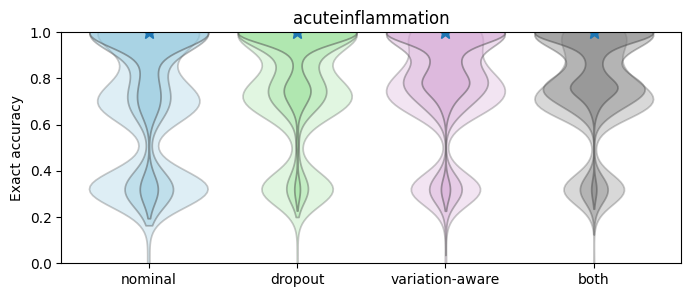

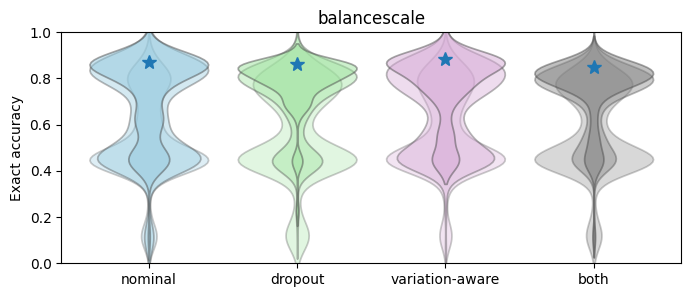

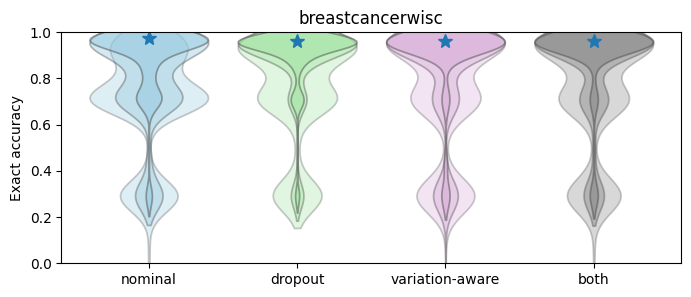

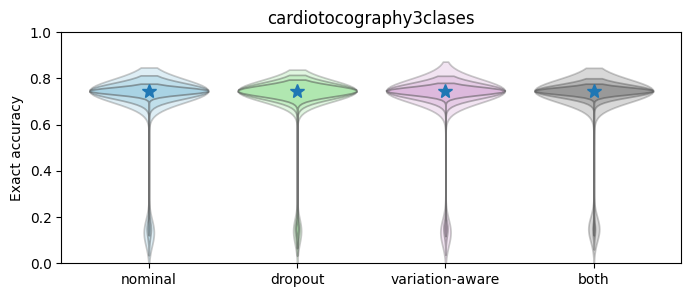

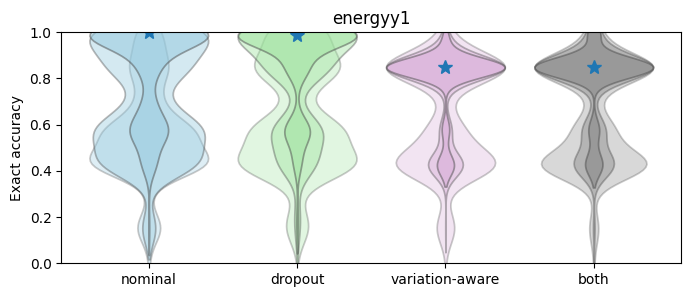

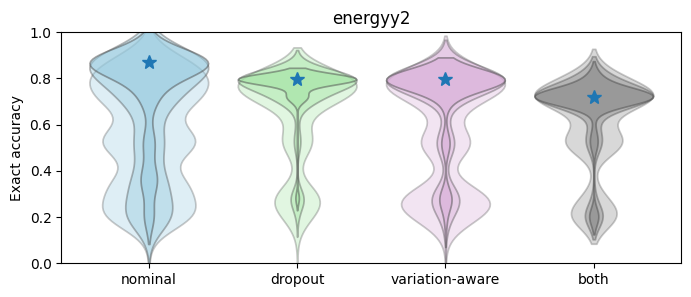

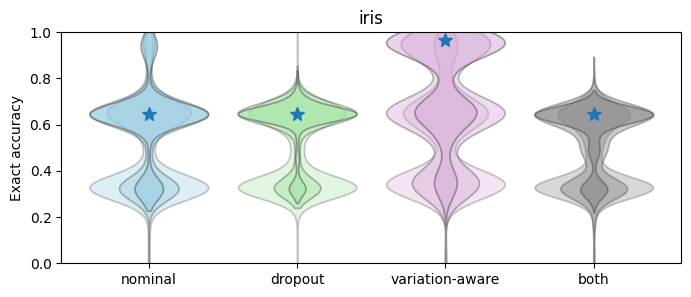

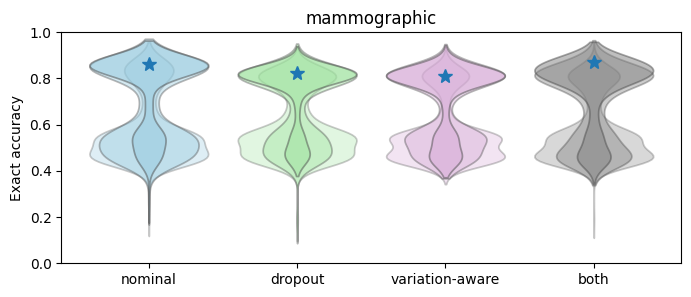

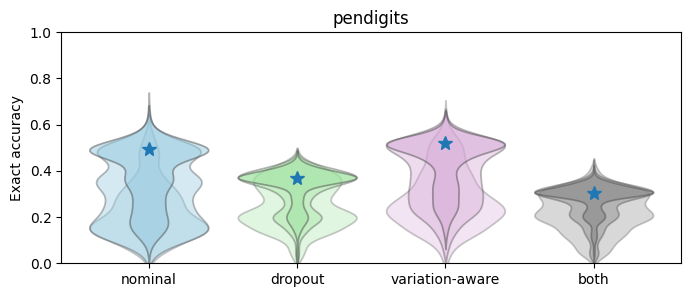

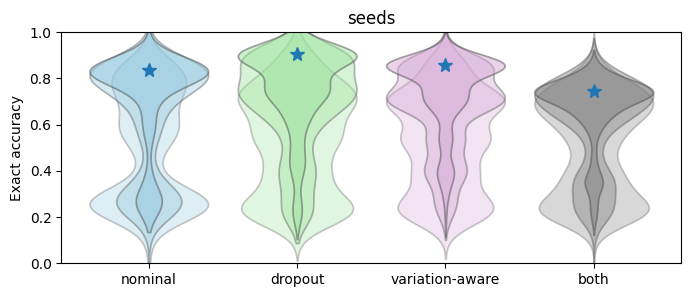

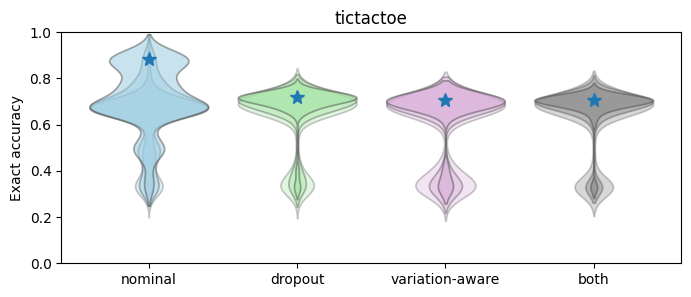

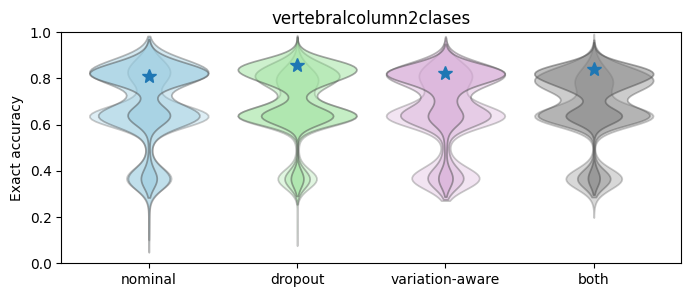

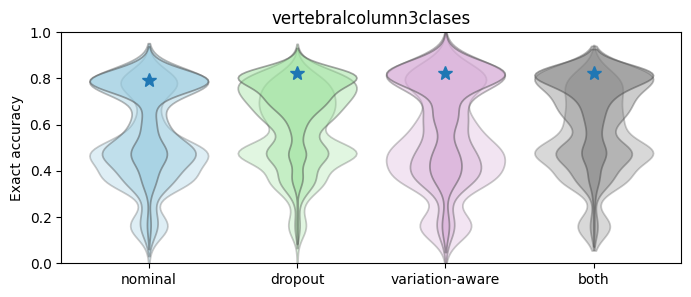

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import matplotlib.patches as mpatches
for ds in range(13):
    
    data_tensor = data_to_visualize[ds,:,:,:]
    plt.figure(figsize=(8, 3))
    
    # Colors and labels for each group
    group_colors = ['skyblue', 'lightgreen', 'plum', 'gray']
    violin_labels = ['nominal', 'dropout', 'variation-aware', 'both']
    
    # Plotting the violin plots with overlapping
    for i in range(data_tensor.shape[1]):
        if not i == 3:
            sns.violinplot(data=data_tensor[:, -1-i, :], palette=group_colors, inner=None, density_norm='area', alpha = 0.1*i+0.3)
        else:
            mean = data_tensor[:, -1-i, :].mean(0)
            plt.plot(np.linspace(0,3,4), mean.numpy(), '*', ms=10)
    
    plt.title(f"{dataname[ds]}")
    # plt.xlabel('Groups')
    plt.xticks(ticks=np.arange(4), labels=violin_labels)
    plt.ylabel('Exact accuracy')
    plt.ylim([0, 1])
    plt.savefig(f"./figures/{ds:02d}_{dataname[ds]}.pdf", format='pdf', bbox_inches='tight', transparent=True)
    plt.show()
    

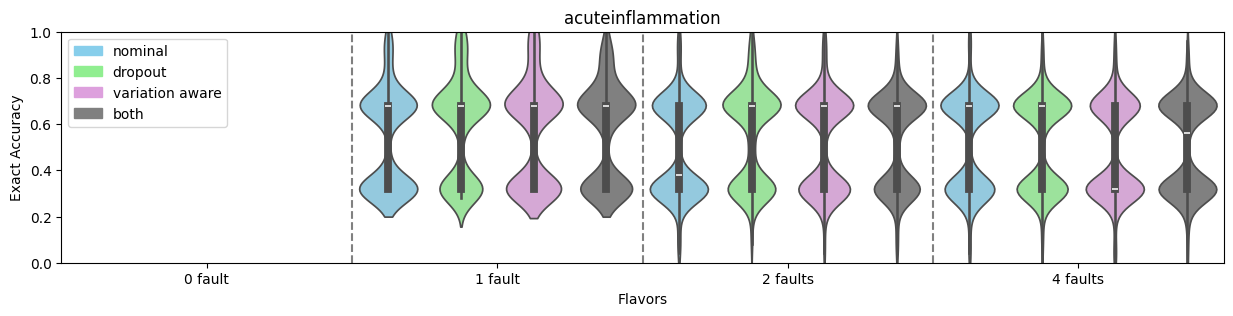

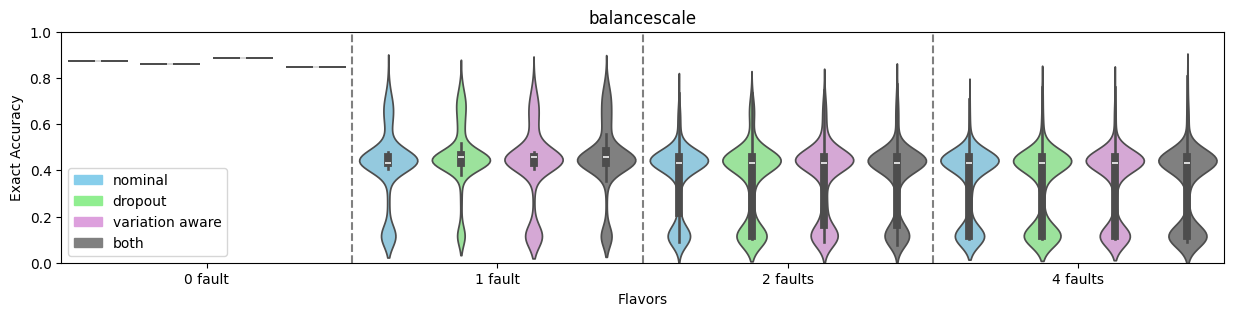

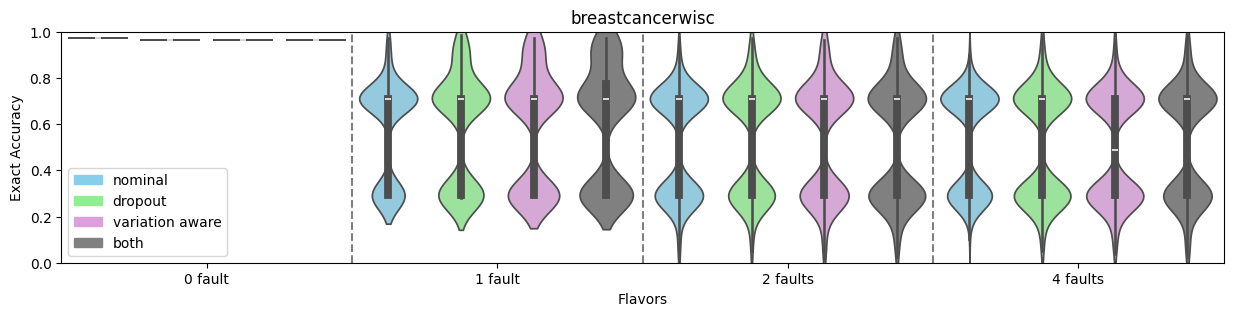

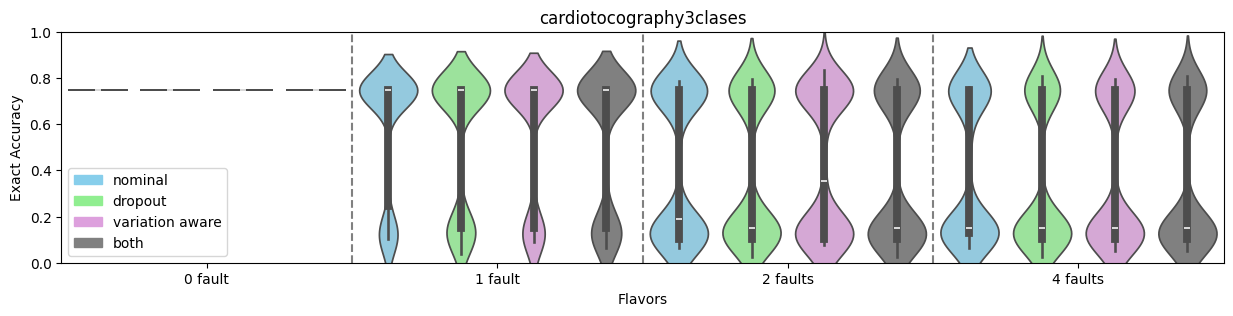

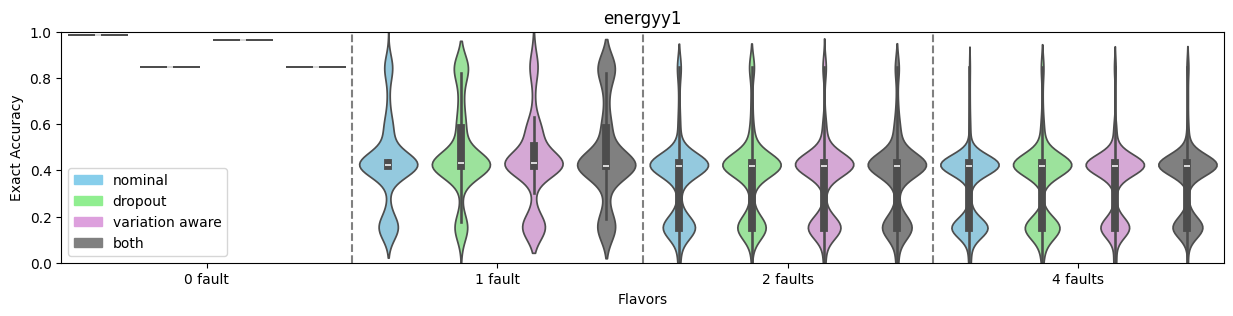

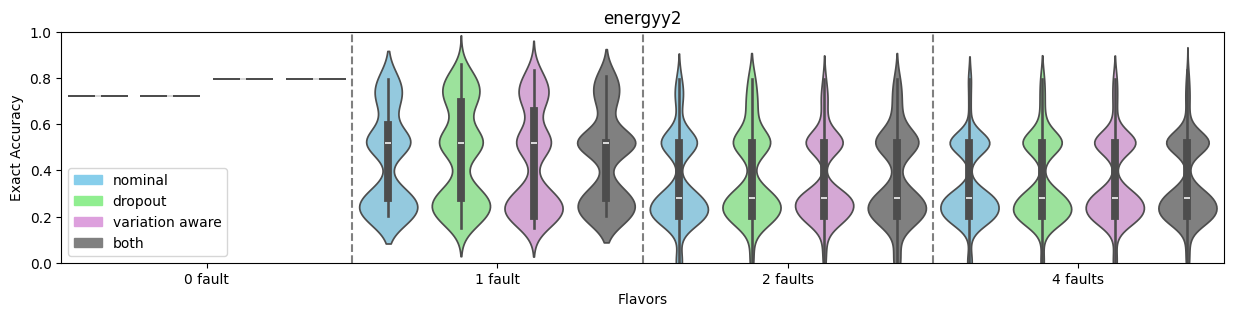

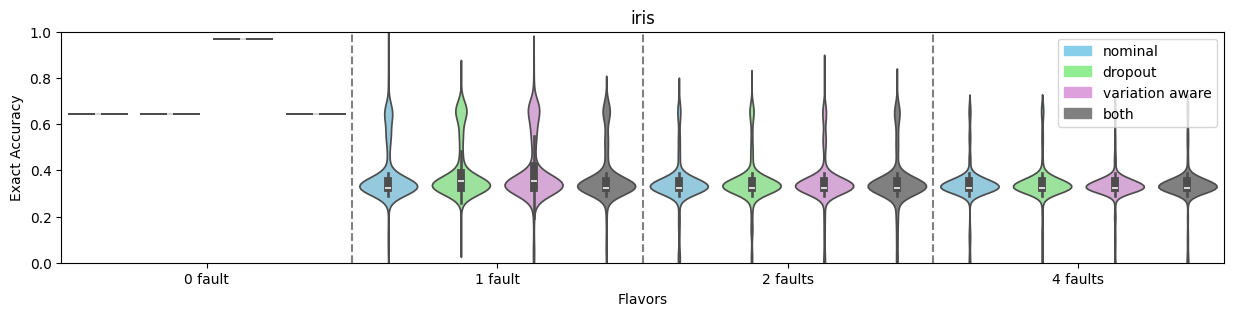

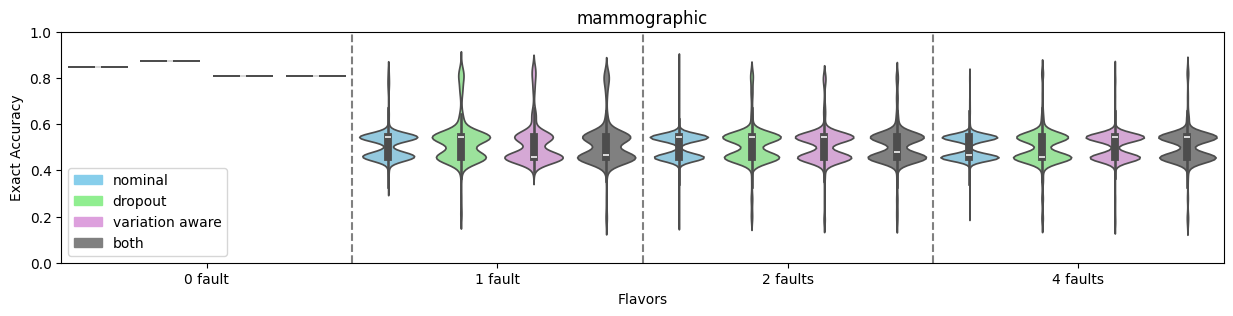

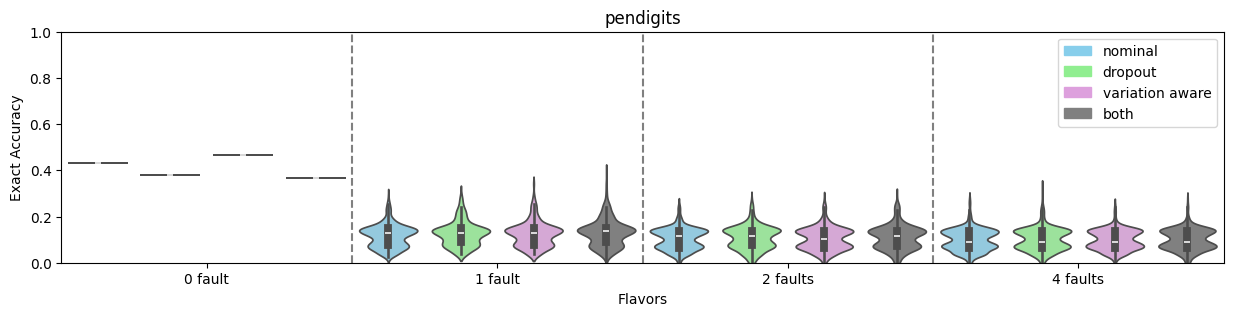

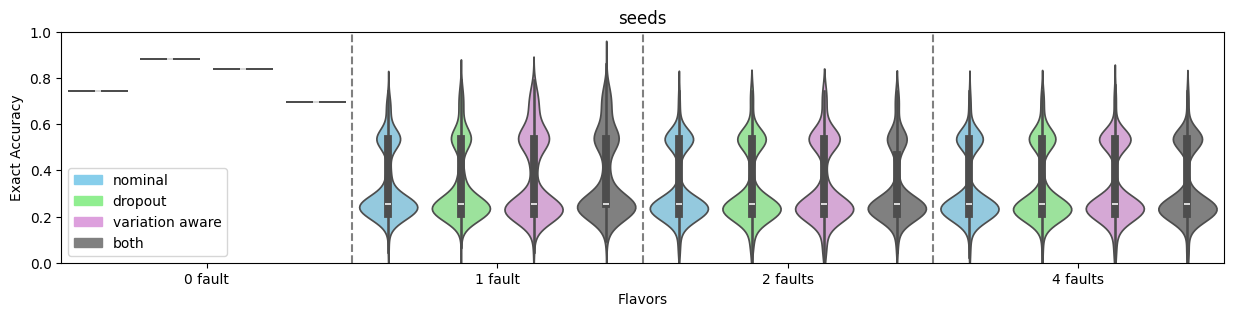

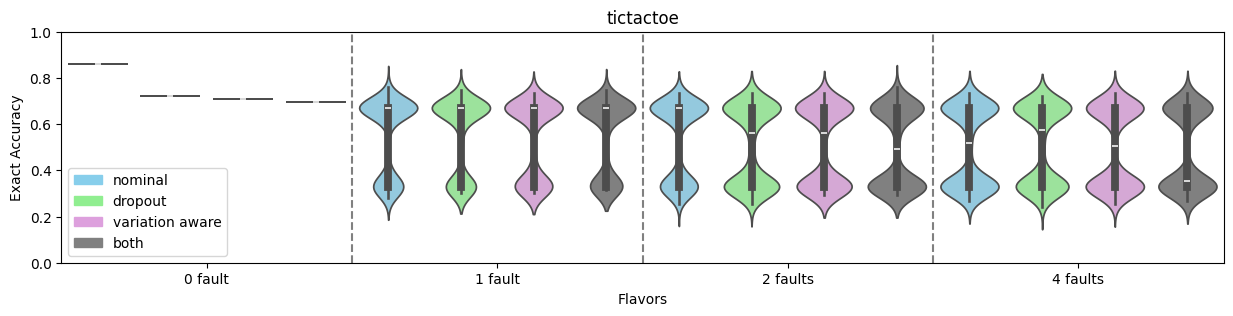

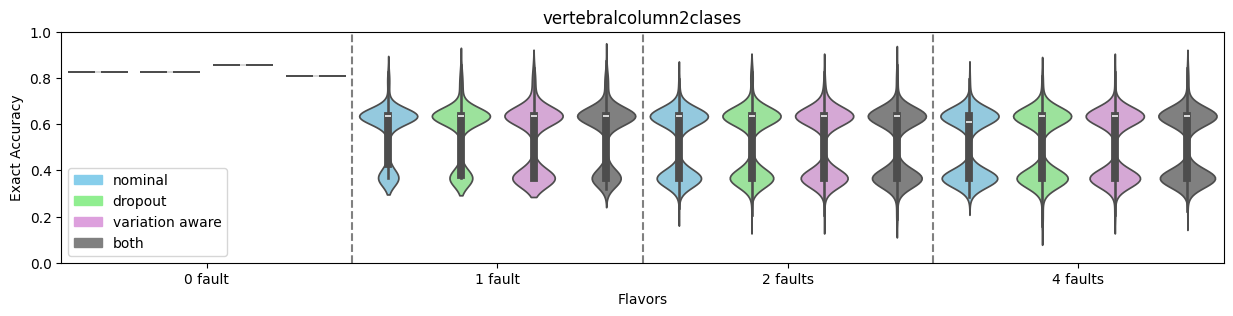

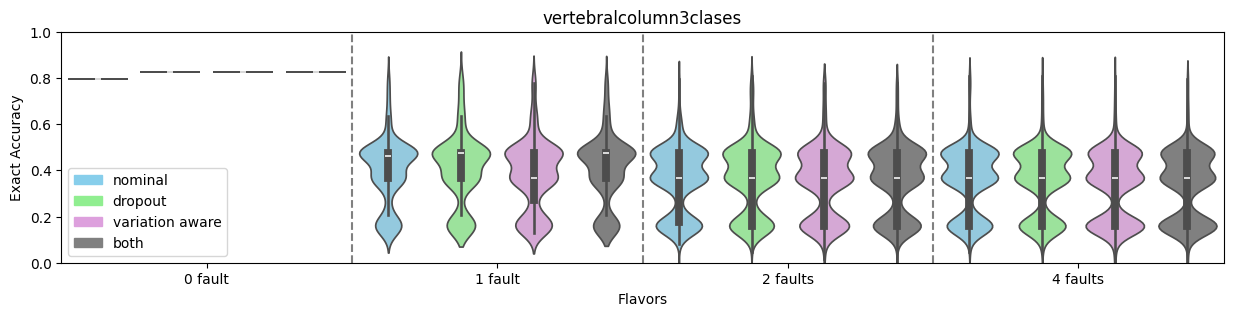

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import matplotlib.patches as mpatches
for ds in range(13):
    
    data_tensor = data_to_visualize[ds,:,:,:]
    # data_tensor = data_tensor.reshape(500, 16)
    data_numpy = data_tensor.numpy().T
    
    plt.figure(figsize=(15, 3))
    group_colors = ['skyblue', 'lightgreen', 'plum', 'gray',
                    'skyblue', 'lightgreen', 'plum', 'gray',
                    'skyblue', 'lightgreen', 'plum', 'gray',
                    'skyblue', 'lightgreen', 'plum', 'gray']

    violin_labels = ['0 fault', '1 fault', '2 faults', '4 faults']

    sns.violinplot(data=data_numpy.T, palette=group_colors)
    # sns.violinplot(data=data_numpy)

    gc = ['skyblue', 'lightgreen', 'plum', 'gray']
    group_names = ['nominal', 'dropout', 'variation aware', 'both']
    
    group_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(gc, group_names)]
    
    plt.axvline(3.5, color='grey', linestyle='--')
    plt.axvline(7.5, color='grey', linestyle='--')
    plt.axvline(11.5, color='grey', linestyle='--')
    plt.title(f'{dataname[ds]}')
    plt.xlabel('Flavors')
    # plt.xticks([1.5],['1'])
    plt.xticks(ticks=np.linspace(1.5,13.5,4), labels=violin_labels)
    # plt.xticks(ticks=np.arange(12))

    plt.ylabel('Exact Accuracy')
    plt.ylim([0,1])
    plt.legend(handles=group_patches)

    plt.show()


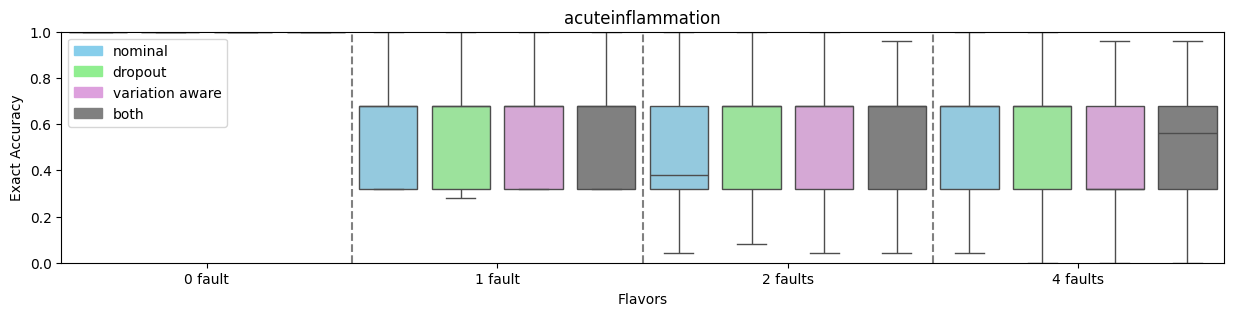

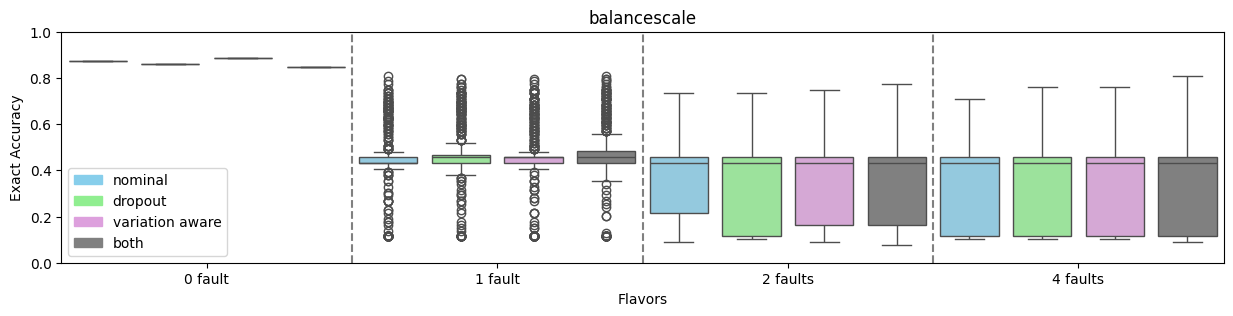

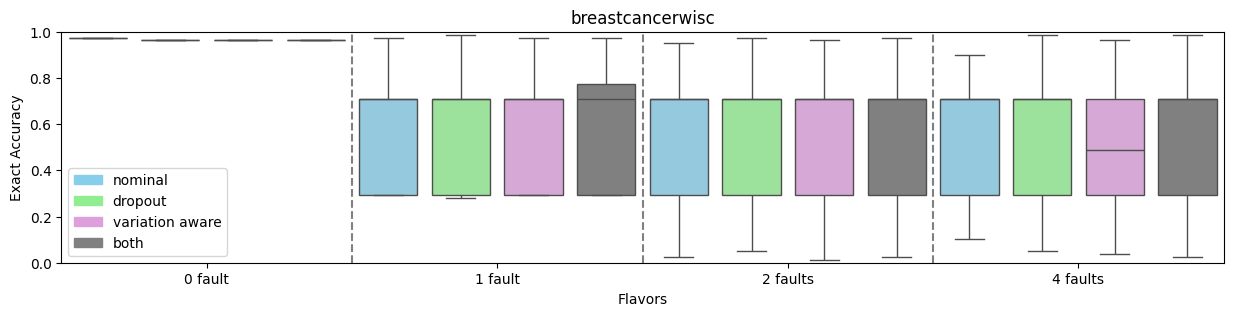

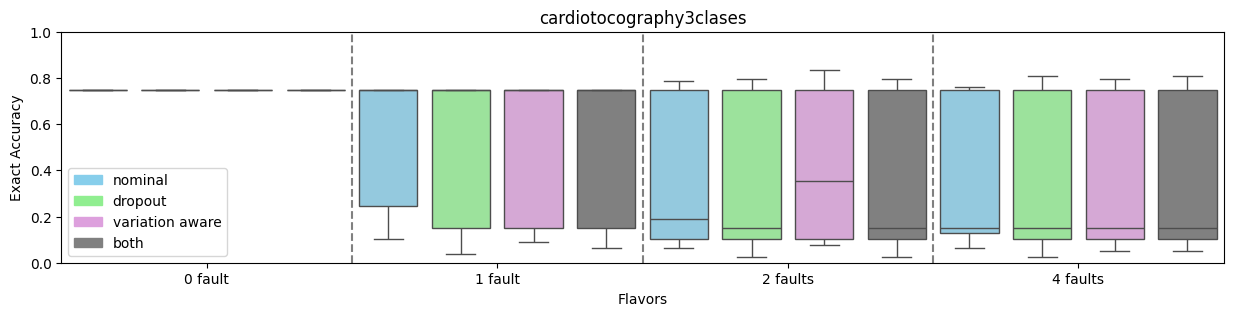

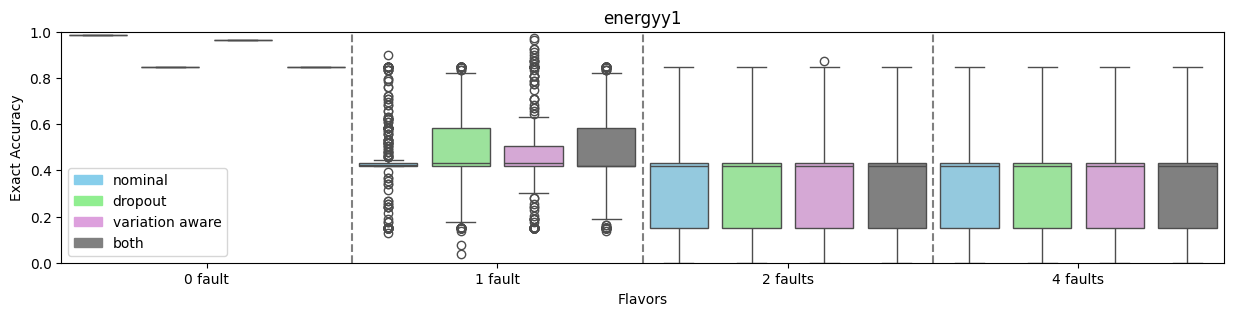

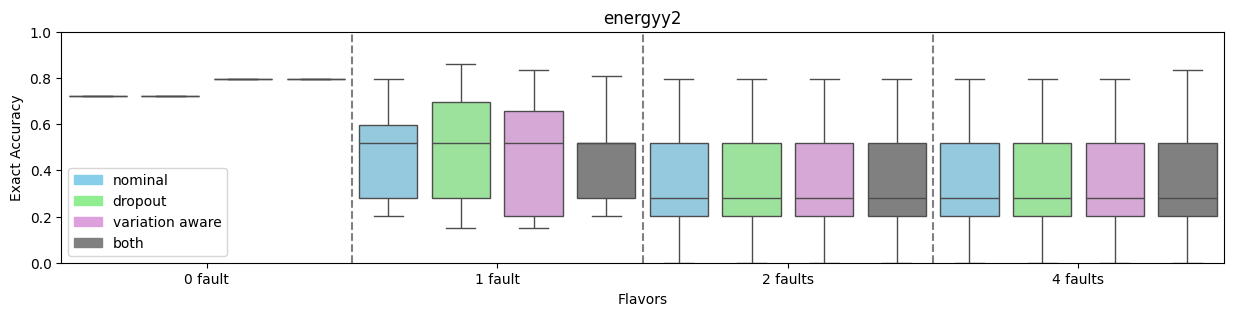

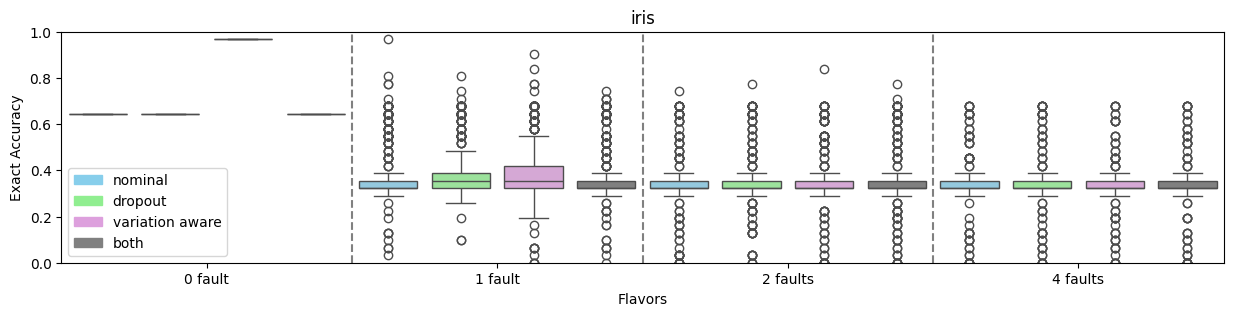

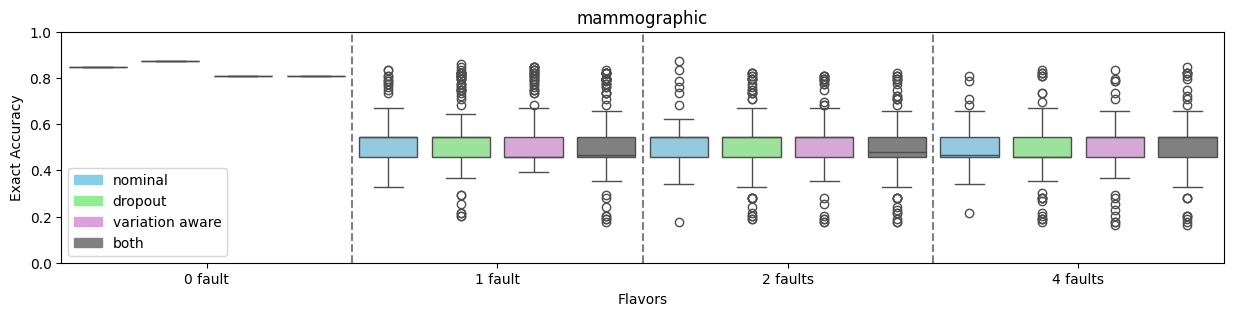

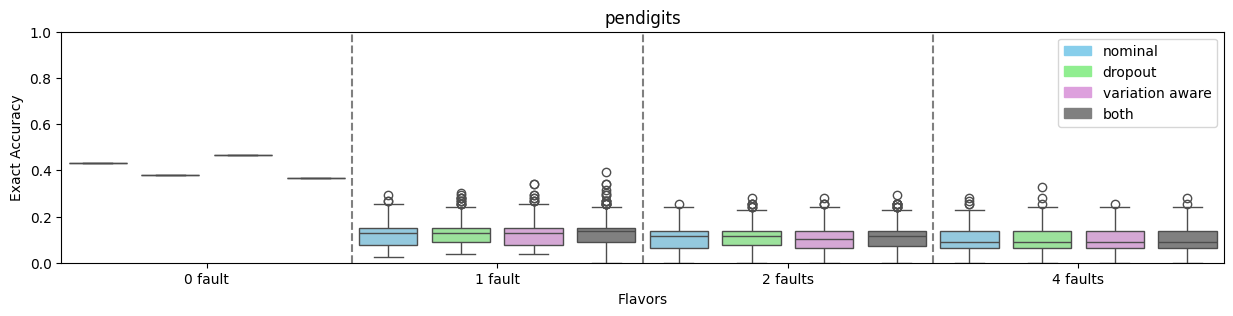

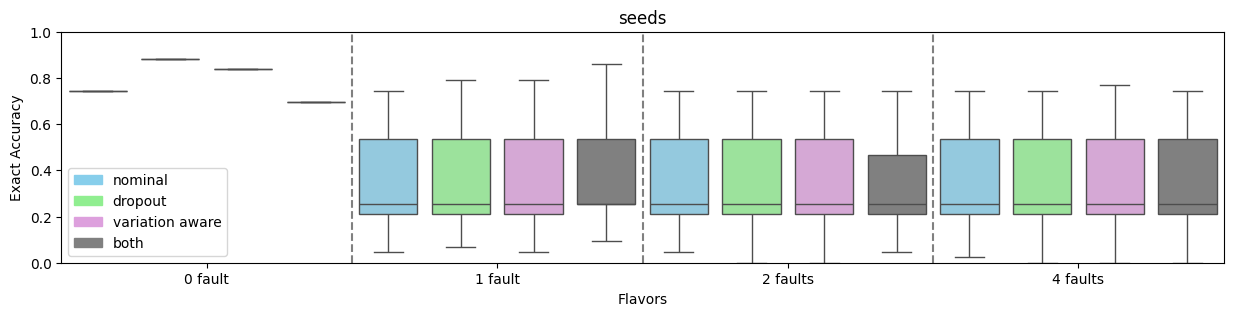

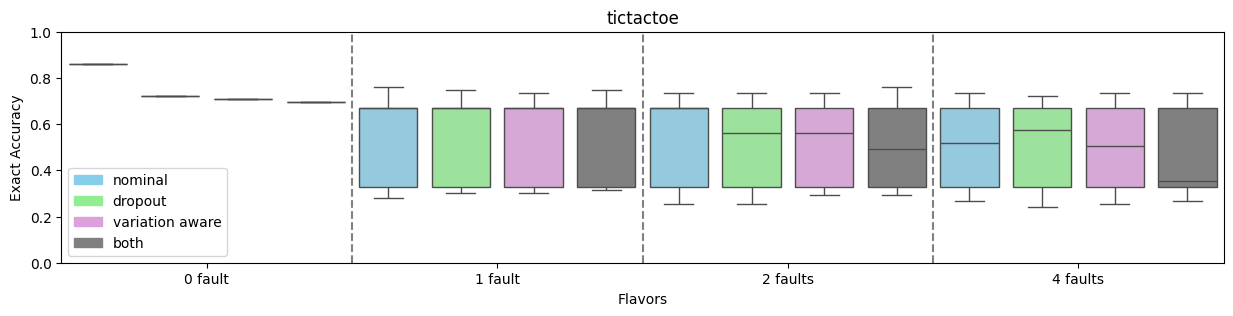

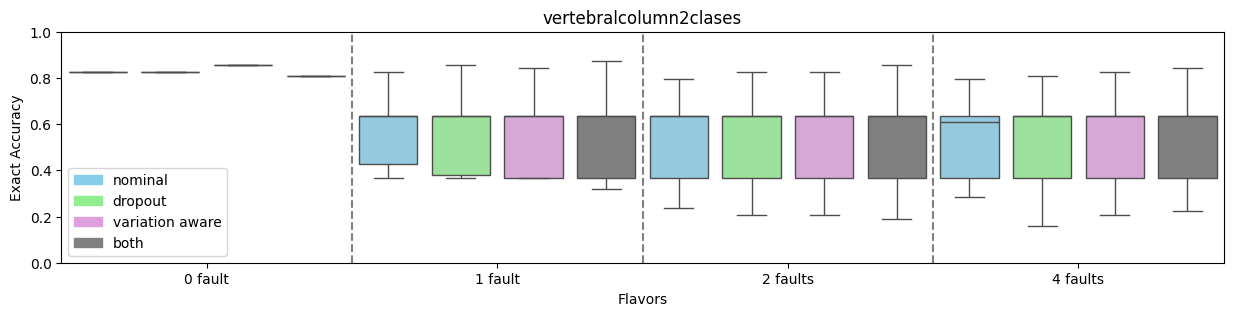

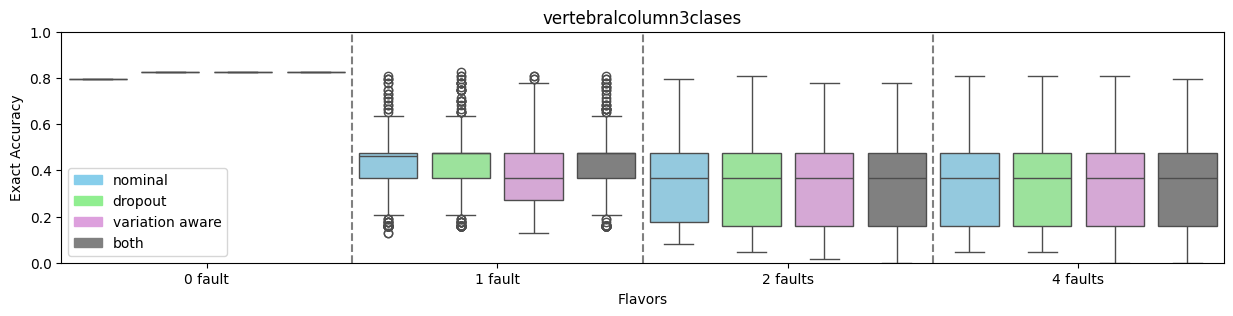

In [65]:
for ds in range(13):
    data_tensor = data_to_visualize[ds, :, :, :]
    data_tensor = data_tensor.reshape(500, 16)
    data_numpy = data_tensor.numpy().T

    plt.figure(figsize=(15, 3))
    group_colors = ['skyblue', 'lightgreen', 'plum', 'gray'] * 4
    violin_labels = ['0 fault', '1 fault', '2 faults', '4 faults']

    # Change from violin plot to box plot
    sns.boxplot(data=data_numpy.T, palette=group_colors)

    gc = ['skyblue', 'lightgreen', 'plum', 'gray']
    group_names = ['nominal', 'dropout', 'variation aware', 'both']

    group_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(gc, group_names)]

    plt.axvline(3.5, color='grey', linestyle='--')
    plt.axvline(7.5, color='grey', linestyle='--')
    plt.axvline(11.5, color='grey', linestyle='--')
    plt.title(f'{dataname[ds]}')
    plt.xlabel('Flavors')
    plt.xticks(ticks=np.linspace(1.5, 13.5, 4), labels=violin_labels)
    plt.ylabel('Exact Accuracy')
    plt.ylim([0, 1])
    plt.legend(handles=group_patches)

    plt.show()

SyntaxError: positional argument follows keyword argument (2561961445.py, line 13)